## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp021'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-3 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

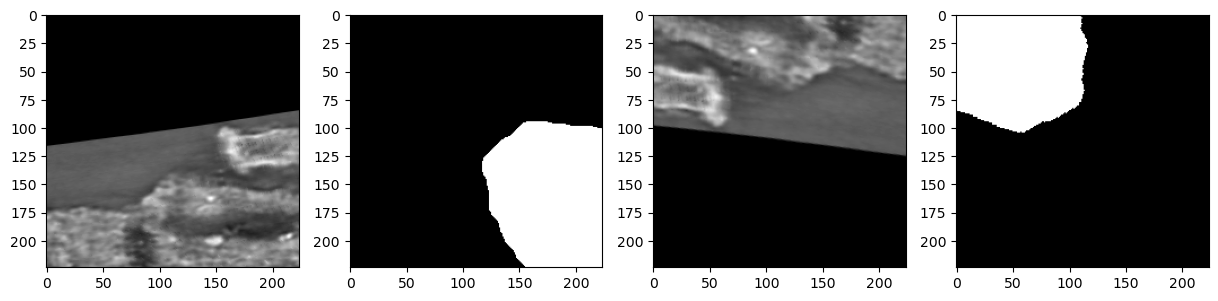

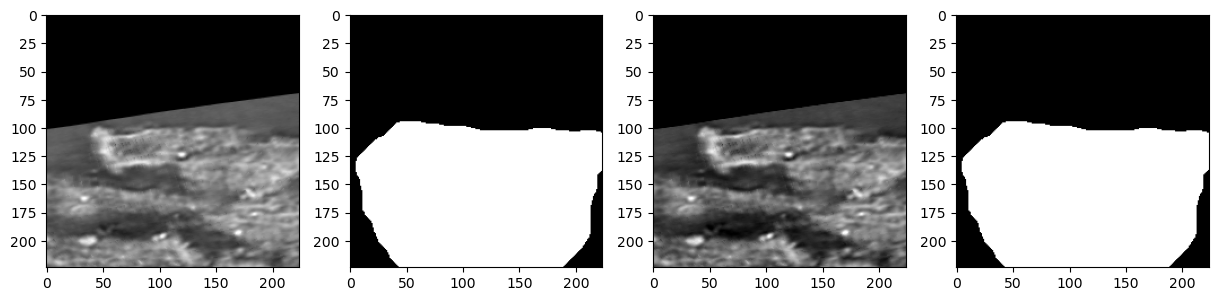

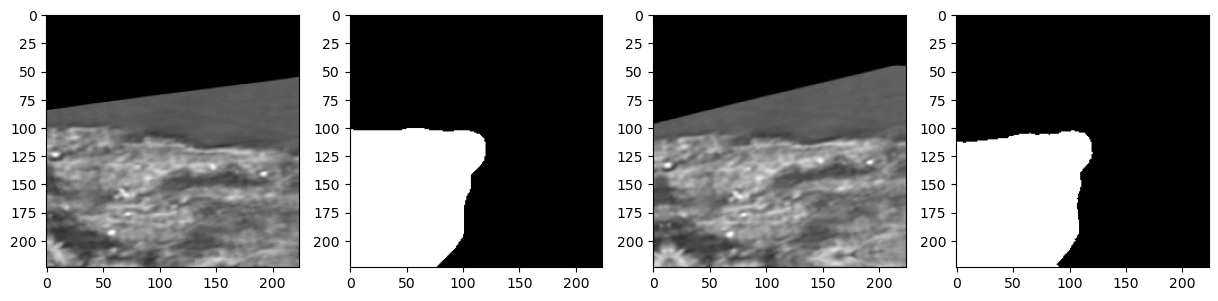

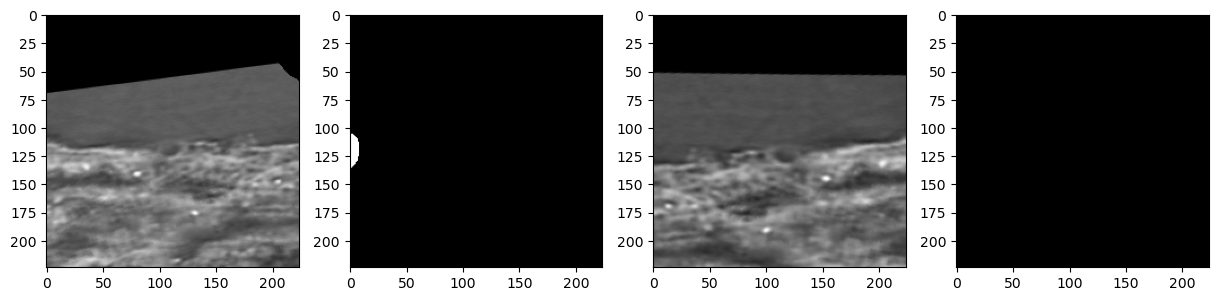

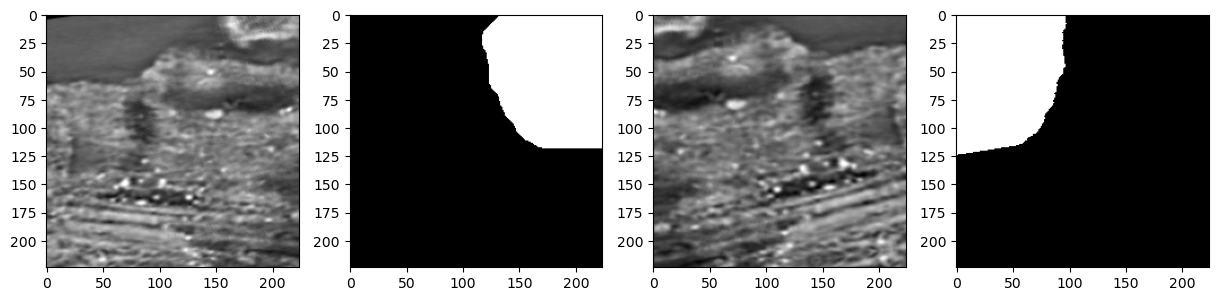

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.2541278402733462
th: 0.15, fbeta: 0.3449603780843282
th: 0.2, fbeta: 0.3822400227362754
th: 0.25, fbeta: 0.3791858634430057
th: 0.3, fbeta: 0.36043352075561746
th: 0.35, fbeta: 0.32693039367887056
th: 0.4, fbeta: 0.28063143383622224
th: 0.45, fbeta: 0.22403817837683532


best_th: 0.2, fbeta: 0.3822400227362754
Epoch 1 - avg_train_loss: 0.3574  avg_val_loss: 0.3162  time: 110s
Epoch 1 - avgScore: 0.3822
Epoch 1 - Save Best Score: 0.3822 Model
Epoch 1 - Save Best Loss: 0.3162 Model


th: 0.5, fbeta: 0.15958810755426073


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35260526624908195
th: 0.15, fbeta: 0.33673507696725036
th: 0.2, fbeta: 0.30033224629838534
th: 0.25, fbeta: 0.25011390315944426
th: 0.3, fbeta: 0.19456786281941552
th: 0.35, fbeta: 0.14772905533610073
th: 0.4, fbeta: 0.11014719525039049
th: 0.45, fbeta: 0.08070964317592932


best_th: 0.1, fbeta: 0.35260526624908195
Epoch 2 - avg_train_loss: 0.2188  avg_val_loss: 0.3836  time: 112s
Epoch 2 - avgScore: 0.3526


th: 0.5, fbeta: 0.053927598060115114


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.286994688564428
th: 0.15, fbeta: 0.3137283102671945
th: 0.2, fbeta: 0.30331033606398944
th: 0.25, fbeta: 0.25655113474603347
th: 0.3, fbeta: 0.15841501436980893
th: 0.35, fbeta: 0.047771806457903604
th: 0.4, fbeta: 0.00948591325608328
th: 0.45, fbeta: 0.0004561952921075818


best_th: 0.15, fbeta: 0.3137283102671945
Epoch 3 - avg_train_loss: 0.2504  avg_val_loss: 0.3342  time: 112s
Epoch 3 - avgScore: 0.3137


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3180232773842349
th: 0.15, fbeta: 0.26928104446481904
th: 0.2, fbeta: 0.13882132594306645
th: 0.25, fbeta: 0.06225664840536817
th: 0.3, fbeta: 0.027805132712824164
th: 0.35, fbeta: 0.012901792501358093
th: 0.4, fbeta: 0.005195616165106879
th: 0.45, fbeta: 0.0018579461966895588


best_th: 0.1, fbeta: 0.3180232773842349
Epoch 4 - avg_train_loss: 0.2270  avg_val_loss: 0.3373  time: 112s
Epoch 4 - avgScore: 0.3180


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29600743309639393
th: 0.15, fbeta: 0.3657660830865294
th: 0.2, fbeta: 0.29997357004756686
th: 0.25, fbeta: 0.2291895682764788
th: 0.3, fbeta: 0.1749567397020948
th: 0.35, fbeta: 0.12977235274182375
th: 0.4, fbeta: 0.09213688489793562
th: 0.45, fbeta: 0.062094413454487


best_th: 0.15, fbeta: 0.3657660830865294
Epoch 5 - avg_train_loss: 0.2175  avg_val_loss: 0.3278  time: 113s
Epoch 5 - avgScore: 0.3658


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2815313522867945
th: 0.15, fbeta: 0.31721806744851677
th: 0.2, fbeta: 0.3459886375024351
th: 0.25, fbeta: 0.35480214242692754
th: 0.3, fbeta: 0.3361756454457574
th: 0.35, fbeta: 0.2980411320179442
th: 0.4, fbeta: 0.250423919283615
th: 0.45, fbeta: 0.19022364118495508


best_th: 0.25, fbeta: 0.35480214242692754
Epoch 6 - avg_train_loss: 0.2142  avg_val_loss: 0.3244  time: 113s
Epoch 6 - avgScore: 0.3548


th: 0.5, fbeta: 0.10464552303883153


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32419053223904715
th: 0.15, fbeta: 0.3566962614746881
th: 0.2, fbeta: 0.3719392906296214
th: 0.25, fbeta: 0.3812795167406488
th: 0.3, fbeta: 0.3847568464198352
th: 0.35, fbeta: 0.3732239982387486
th: 0.4, fbeta: 0.34692808842281836
th: 0.45, fbeta: 0.29745189624831275


best_th: 0.3, fbeta: 0.3847568464198352
Epoch 7 - avg_train_loss: 0.2114  avg_val_loss: 0.3379  time: 113s
Epoch 7 - avgScore: 0.3848
Epoch 7 - Save Best Score: 0.3848 Model
Epoch 7 - Save Best Loss: 0.3379 Model


th: 0.5, fbeta: 0.21762522531841394


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3809125085107691
th: 0.15, fbeta: 0.4031612979509269
th: 0.2, fbeta: 0.3867755111661803
th: 0.25, fbeta: 0.3582519493751873
th: 0.3, fbeta: 0.3208602121556763
th: 0.35, fbeta: 0.28322513207740535
th: 0.4, fbeta: 0.24513525807272463
th: 0.45, fbeta: 0.2081126612768655


best_th: 0.15, fbeta: 0.4031612979509269
Epoch 8 - avg_train_loss: 0.2073  avg_val_loss: 0.3634  time: 113s
Epoch 8 - avgScore: 0.4032
Epoch 8 - Save Best Score: 0.4032 Model
Epoch 8 - Save Best Loss: 0.3634 Model


th: 0.5, fbeta: 0.17040897732309637


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3334537628477543
th: 0.15, fbeta: 0.37111881628781923
th: 0.2, fbeta: 0.3914377348333226
th: 0.25, fbeta: 0.39288133892652805
th: 0.3, fbeta: 0.3759809169054792
th: 0.35, fbeta: 0.338401066308684
th: 0.4, fbeta: 0.28204157171907274
th: 0.45, fbeta: 0.21759967763886606


best_th: 0.25, fbeta: 0.39288133892652805
Epoch 9 - avg_train_loss: 0.2039  avg_val_loss: 0.3681  time: 112s
Epoch 9 - avgScore: 0.3929


th: 0.5, fbeta: 0.15677672224946282


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3798823853458943
th: 0.15, fbeta: 0.26458032714930946
th: 0.2, fbeta: 0.15952630499944395
th: 0.25, fbeta: 0.0930963156645934
th: 0.3, fbeta: 0.05450895394043698
th: 0.35, fbeta: 0.034787861447526144
th: 0.4, fbeta: 0.02366629763587645
th: 0.45, fbeta: 0.016898154961913665


best_th: 0.1, fbeta: 0.3798823853458943
Epoch 10 - avg_train_loss: 0.2015  avg_val_loss: 0.4385  time: 113s
Epoch 10 - avgScore: 0.3799


th: 0.5, fbeta: 0.011998205536417778


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34707613372604046
th: 0.15, fbeta: 0.365529499141858
th: 0.2, fbeta: 0.36786753146019036
th: 0.25, fbeta: 0.3558021235110699
th: 0.3, fbeta: 0.33622271119777764
th: 0.35, fbeta: 0.3103124739524808
th: 0.4, fbeta: 0.2845674681605639
th: 0.45, fbeta: 0.25928890813192107


best_th: 0.2, fbeta: 0.36786753146019036
Epoch 11 - avg_train_loss: 0.1990  avg_val_loss: 0.3713  time: 113s
Epoch 11 - avgScore: 0.3679


th: 0.5, fbeta: 0.2309363230692561


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3863123561992568
th: 0.15, fbeta: 0.4018172567365894
th: 0.2, fbeta: 0.40093019034190375
th: 0.25, fbeta: 0.3835188860153257
th: 0.3, fbeta: 0.3545272727133244
th: 0.35, fbeta: 0.31359481610773704
th: 0.4, fbeta: 0.2706567885402139
th: 0.45, fbeta: 0.22908390859622518


best_th: 0.15, fbeta: 0.4018172567365894
Epoch 12 - avg_train_loss: 0.1942  avg_val_loss: 0.4524  time: 113s
Epoch 12 - avgScore: 0.4018


th: 0.5, fbeta: 0.1887519909613975


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39186361178037066
th: 0.15, fbeta: 0.397221787135442
th: 0.2, fbeta: 0.3811763235454948
th: 0.25, fbeta: 0.3499647535002069
th: 0.3, fbeta: 0.31091641580888196
th: 0.35, fbeta: 0.27040599162349643
th: 0.4, fbeta: 0.2307488991480368
th: 0.45, fbeta: 0.19059811989552328


best_th: 0.15, fbeta: 0.397221787135442
Epoch 13 - avg_train_loss: 0.1908  avg_val_loss: 0.3928  time: 113s
Epoch 13 - avgScore: 0.3972


th: 0.5, fbeta: 0.1534067794825655


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39475758086609464
th: 0.15, fbeta: 0.4023098037698761
th: 0.2, fbeta: 0.3738293460894173
th: 0.25, fbeta: 0.3256544248009654
th: 0.3, fbeta: 0.26908027137605794
th: 0.35, fbeta: 0.21456261636393076
th: 0.4, fbeta: 0.1625344812665068
th: 0.45, fbeta: 0.11700119362818885


best_th: 0.15, fbeta: 0.4023098037698761
Epoch 14 - avg_train_loss: 0.1891  avg_val_loss: 0.3880  time: 113s
Epoch 14 - avgScore: 0.4023


th: 0.5, fbeta: 0.08260404733751645


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3963834777715703
th: 0.15, fbeta: 0.41639914229651026
th: 0.2, fbeta: 0.4202542060755937
th: 0.25, fbeta: 0.40983902232955477
th: 0.3, fbeta: 0.39235228751251416
th: 0.35, fbeta: 0.36708384351614715
th: 0.4, fbeta: 0.33571757346045966
th: 0.45, fbeta: 0.301231329503795


best_th: 0.2, fbeta: 0.4202542060755937
Epoch 15 - avg_train_loss: 0.1894  avg_val_loss: 0.3910  time: 114s
Epoch 15 - avgScore: 0.4203
Epoch 15 - Save Best Score: 0.4203 Model
Epoch 15 - Save Best Loss: 0.3910 Model


th: 0.5, fbeta: 0.26431880325557


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36507360250408805
th: 0.15, fbeta: 0.31382908757082295
th: 0.2, fbeta: 0.25336673902578616
th: 0.25, fbeta: 0.1942345890359452
th: 0.3, fbeta: 0.1440271367935389
th: 0.35, fbeta: 0.10493235241244281
th: 0.4, fbeta: 0.07639611539495511
th: 0.45, fbeta: 0.05337409666637395


best_th: 0.1, fbeta: 0.36507360250408805
Epoch 16 - avg_train_loss: 0.1851  avg_val_loss: 0.4807  time: 114s
Epoch 16 - avgScore: 0.3651


th: 0.5, fbeta: 0.0363720659391277


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40032067906648333
th: 0.15, fbeta: 0.388027382983494
th: 0.2, fbeta: 0.34729414451931073
th: 0.25, fbeta: 0.2901605973710193
th: 0.3, fbeta: 0.2273667506865515
th: 0.35, fbeta: 0.17176336083322288
th: 0.4, fbeta: 0.12833158891598434
th: 0.45, fbeta: 0.09606255170675645


best_th: 0.1, fbeta: 0.40032067906648333
Epoch 17 - avg_train_loss: 0.1821  avg_val_loss: 0.4075  time: 112s
Epoch 17 - avgScore: 0.4003


th: 0.5, fbeta: 0.06858846078517482


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4006764587554065
th: 0.15, fbeta: 0.41195536218080286
th: 0.2, fbeta: 0.39911717339169506
th: 0.25, fbeta: 0.3698841727369815
th: 0.3, fbeta: 0.3347169059592842
th: 0.35, fbeta: 0.30161272199076133
th: 0.4, fbeta: 0.26878789572644035
th: 0.45, fbeta: 0.23614585347255831


best_th: 0.15, fbeta: 0.41195536218080286
Epoch 18 - avg_train_loss: 0.1799  avg_val_loss: 0.4051  time: 113s
Epoch 18 - avgScore: 0.4120


th: 0.5, fbeta: 0.2029481862619424


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37888458357931837
th: 0.15, fbeta: 0.3632798366325347
th: 0.2, fbeta: 0.32600748685972386
th: 0.25, fbeta: 0.28178014997147655
th: 0.3, fbeta: 0.23713526801696314
th: 0.35, fbeta: 0.19192535827190113
th: 0.4, fbeta: 0.14965942715022826
th: 0.45, fbeta: 0.11700830937265261


best_th: 0.1, fbeta: 0.37888458357931837
Epoch 19 - avg_train_loss: 0.1742  avg_val_loss: 0.4104  time: 113s
Epoch 19 - avgScore: 0.3789


th: 0.5, fbeta: 0.08972596422576191


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39038112336701014
th: 0.15, fbeta: 0.38838294164725734
th: 0.2, fbeta: 0.3603068588107385
th: 0.25, fbeta: 0.3211974124902764
th: 0.3, fbeta: 0.27687423881174406
th: 0.35, fbeta: 0.23123484125319663
th: 0.4, fbeta: 0.18682140969534242
th: 0.45, fbeta: 0.15112124826598256


best_th: 0.1, fbeta: 0.39038112336701014
Epoch 20 - avg_train_loss: 0.1740  avg_val_loss: 0.4206  time: 113s
Epoch 20 - avgScore: 0.3904


th: 0.5, fbeta: 0.11910929879753117


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3541862802485668
th: 0.15, fbeta: 0.29793959664975245
th: 0.2, fbeta: 0.23495257682460424
th: 0.25, fbeta: 0.17971762661490578
th: 0.3, fbeta: 0.14002125608762225
th: 0.35, fbeta: 0.11077644969453647
th: 0.4, fbeta: 0.08766182446255351
th: 0.45, fbeta: 0.06573898478325681


best_th: 0.1, fbeta: 0.3541862802485668
Epoch 21 - avg_train_loss: 0.1699  avg_val_loss: 0.5066  time: 113s
Epoch 21 - avgScore: 0.3542


th: 0.5, fbeta: 0.045725138890429534


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3949557888454631
th: 0.15, fbeta: 0.38520607846594035
th: 0.2, fbeta: 0.3489663328425575
th: 0.25, fbeta: 0.30522931883659504
th: 0.3, fbeta: 0.25993586879937913
th: 0.35, fbeta: 0.21875509076542474
th: 0.4, fbeta: 0.18034884515506786
th: 0.45, fbeta: 0.14682982136326003


best_th: 0.1, fbeta: 0.3949557888454631
Epoch 22 - avg_train_loss: 0.1674  avg_val_loss: 0.5235  time: 113s
Epoch 22 - avgScore: 0.3950


th: 0.5, fbeta: 0.11971381980920039


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40660779231852945
th: 0.15, fbeta: 0.41650720883913767
th: 0.2, fbeta: 0.405499476293975
th: 0.25, fbeta: 0.3848784251948725
th: 0.3, fbeta: 0.3511675917481877
th: 0.35, fbeta: 0.3120324476262495
th: 0.4, fbeta: 0.27175229614582547
th: 0.45, fbeta: 0.2363766152962228


best_th: 0.15, fbeta: 0.41650720883913767
Epoch 23 - avg_train_loss: 0.1628  avg_val_loss: 0.4540  time: 113s
Epoch 23 - avgScore: 0.4165


th: 0.5, fbeta: 0.20387816635315362


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40030926293924424
th: 0.15, fbeta: 0.39285708660209856
th: 0.2, fbeta: 0.37030797589320597
th: 0.25, fbeta: 0.3414833136132122
th: 0.3, fbeta: 0.3071948675761723
th: 0.35, fbeta: 0.26685284760722505
th: 0.4, fbeta: 0.22708460962097315
th: 0.45, fbeta: 0.19548293050843352


best_th: 0.1, fbeta: 0.40030926293924424
Epoch 24 - avg_train_loss: 0.1586  avg_val_loss: 0.5175  time: 113s
Epoch 24 - avgScore: 0.4003


th: 0.5, fbeta: 0.16446899056082614


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3888627361716897
th: 0.15, fbeta: 0.3903440768222186
th: 0.2, fbeta: 0.37469342548177037
th: 0.25, fbeta: 0.3404923366091709
th: 0.3, fbeta: 0.30040283131121465
th: 0.35, fbeta: 0.2639563691335856
th: 0.4, fbeta: 0.2288891412313812
th: 0.45, fbeta: 0.19736085973388265


best_th: 0.15, fbeta: 0.3903440768222186
Epoch 25 - avg_train_loss: 0.1598  avg_val_loss: 0.4883  time: 113s
Epoch 25 - avgScore: 0.3903


th: 0.5, fbeta: 0.16895302760613443


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38033811273267487
th: 0.15, fbeta: 0.39201803592138823
th: 0.2, fbeta: 0.3903124291998911
th: 0.25, fbeta: 0.3806131337207874
th: 0.3, fbeta: 0.35822683348403234
th: 0.35, fbeta: 0.3272995292371724
th: 0.4, fbeta: 0.29221978260880227
th: 0.45, fbeta: 0.259244596969042


best_th: 0.15, fbeta: 0.39201803592138823
Epoch 26 - avg_train_loss: 0.1553  avg_val_loss: 0.4740  time: 113s
Epoch 26 - avgScore: 0.3920


th: 0.5, fbeta: 0.22810065920390046


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3783584529923345
th: 0.15, fbeta: 0.3647571189039159
th: 0.2, fbeta: 0.34063474856818743
th: 0.25, fbeta: 0.30948204080951147
th: 0.3, fbeta: 0.2764850845809685
th: 0.35, fbeta: 0.24159418177327074
th: 0.4, fbeta: 0.2047827936969489
th: 0.45, fbeta: 0.1722897400574101


best_th: 0.1, fbeta: 0.3783584529923345
Epoch 27 - avg_train_loss: 0.1546  avg_val_loss: 0.5266  time: 113s
Epoch 27 - avgScore: 0.3784


th: 0.5, fbeta: 0.14496403271515493


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3863808118673183
th: 0.15, fbeta: 0.38632210432229364
th: 0.2, fbeta: 0.36833171846077306
th: 0.25, fbeta: 0.3419400591831694
th: 0.3, fbeta: 0.3102646572438113
th: 0.35, fbeta: 0.27786653542927137
th: 0.4, fbeta: 0.2470430679490676
th: 0.45, fbeta: 0.21604064789424463


best_th: 0.1, fbeta: 0.3863808118673183
Epoch 28 - avg_train_loss: 0.1504  avg_val_loss: 0.4962  time: 113s
Epoch 28 - avgScore: 0.3864


th: 0.5, fbeta: 0.18527329928816624


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39258521738280616
th: 0.15, fbeta: 0.3928376227355759
th: 0.2, fbeta: 0.3769474336359612
th: 0.25, fbeta: 0.35005069319865917
th: 0.3, fbeta: 0.31766272720581523
th: 0.35, fbeta: 0.28157085375127666
th: 0.4, fbeta: 0.24696861844653173
th: 0.45, fbeta: 0.21530923501170637


best_th: 0.15, fbeta: 0.3928376227355759
Epoch 29 - avg_train_loss: 0.1467  avg_val_loss: 0.4896  time: 113s
Epoch 29 - avgScore: 0.3928


th: 0.5, fbeta: 0.18355272442150822


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3862580657023415
th: 0.15, fbeta: 0.36749802219674427
th: 0.2, fbeta: 0.3279830825347842
th: 0.25, fbeta: 0.2805905597772486
th: 0.3, fbeta: 0.2371745103410132
th: 0.35, fbeta: 0.1963157013502683
th: 0.4, fbeta: 0.15897204455516623
th: 0.45, fbeta: 0.12856447736300855


best_th: 0.1, fbeta: 0.3862580657023415
Epoch 30 - avg_train_loss: 0.1490  avg_val_loss: 0.5235  time: 112s
Epoch 30 - avgScore: 0.3863


th: 0.5, fbeta: 0.10479957063789633


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3963834777715703
th: 0.15, fbeta: 0.41639914229651026
th: 0.2, fbeta: 0.4202542060755937
th: 0.25, fbeta: 0.40983902232955477
th: 0.3, fbeta: 0.39235228751251416
th: 0.35, fbeta: 0.36708384351614715
th: 0.4, fbeta: 0.33571757346045966
th: 0.45, fbeta: 0.301231329503795


best_th: 0.2, fbeta: 0.4202542060755937


th: 0.5, fbeta: 0.26431880325557


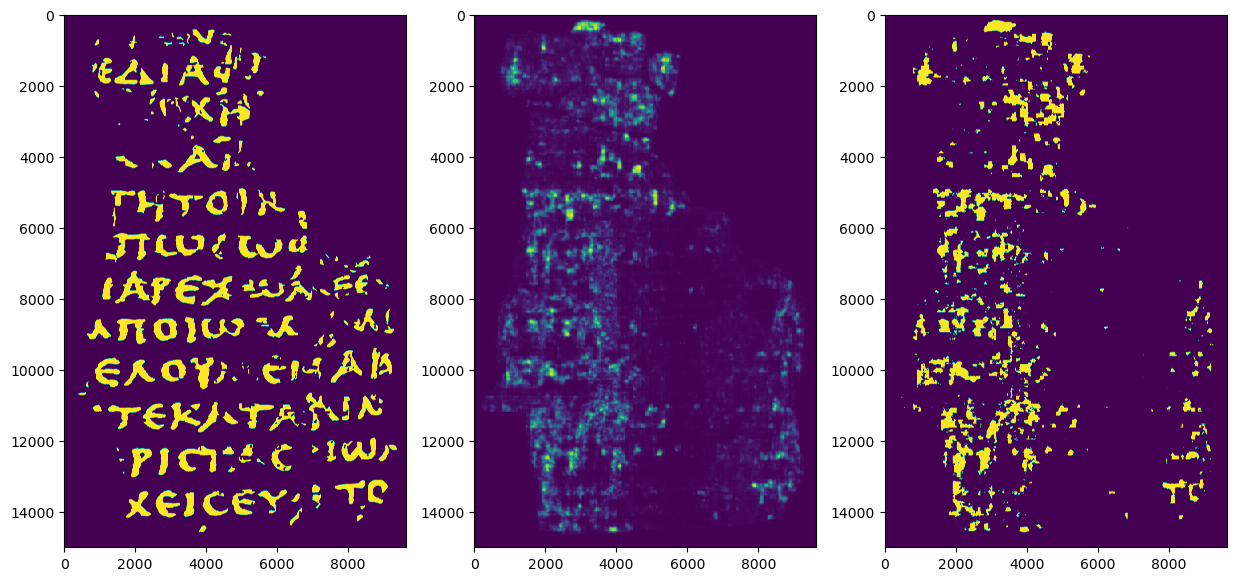

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.12355197e+08, 1.28026730e+07, 5.83492900e+06, 3.55448900e+06,
        2.38640200e+06, 1.75819400e+06, 1.29828500e+06, 1.01415100e+06,
        7.82632000e+05, 5.94859000e+05, 4.58484000e+05, 3.68520000e+05,
        2.91678000e+05, 2.42139000e+05, 2.24132000e+05, 1.94798000e+05,
        1.83464000e+05, 1.38925000e+05, 6.00100000e+04, 1.30950000e+04]),
 array([1.06834315e-12, 4.90107447e-02, 9.80214894e-02, 1.47032234e-01,
        1.96042979e-01, 2.45053723e-01, 2.94064468e-01, 3.43075213e-01,
        3.92085958e-01, 4.41096702e-01, 4.90107447e-01, 5.39118192e-01,
        5.88128936e-01, 6.37139681e-01, 6.86150426e-01, 7.35161170e-01,
        7.84171915e-01, 8.33182660e-01, 8.82193404e-01, 9.31204149e-01,
        9.80214894e-01]),
 <BarContainer object of 20 artists>)

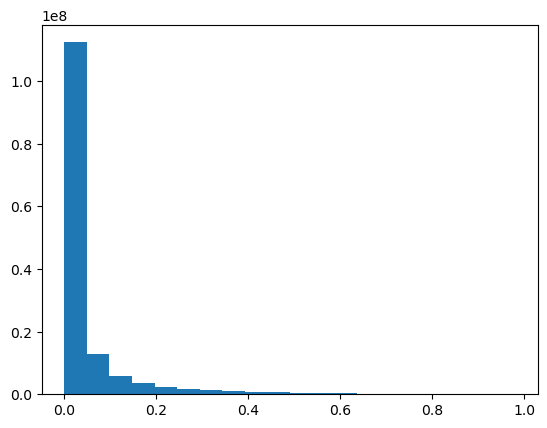

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000